In [1]:
import read_Data
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import methods
import datetime
import utils

## Load Data

In [2]:


source=3
profile_hours=150

dftelemetry,dfcontext,failures=read_Data.AzureDataOneSource(source=source)
dfs,isfailure=read_Data.split_df_with_failures_isfaile(dftelemetry, failures)
dfs_context,_=read_Data.split_df_with_failures_isfaile(dfcontext, failures)

list_train, list_test,context_list_dfs,isfailure,all_sources = read_Data.Azure_generate_train_test(dfs,isfailure,dfs_context,[source for i in dfs], period_or_count=f"{profile_hours} hours")

In [3]:
# Helper Functions


#scale only for ploting
def plot_scale_df(df,ax):
    scaled_data = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_data, columns=df.columns)
    scaled_df.index=df.index
    scaled_df.plot(ax=ax,alpha=0.7,linewidth=1,legend=False)



def generate_scores(train,test,detector,window_for_threshold,smooth_window):
    # apply anomaly detector
    scores = detector(dftrain, dftest)
    # apply thresholding technique
    scores = utils.self_tunning(scores, window_length=window_for_threshold)
    # apply smoothing
    scores = utils.moving_median(smooth_window, scores)

    return scores

# Ploting Data:

We can see in green color the data will be used to train OCSVM in each episode, where each episode takes place after the end of its previous in time. In red color we can see the period before failure.

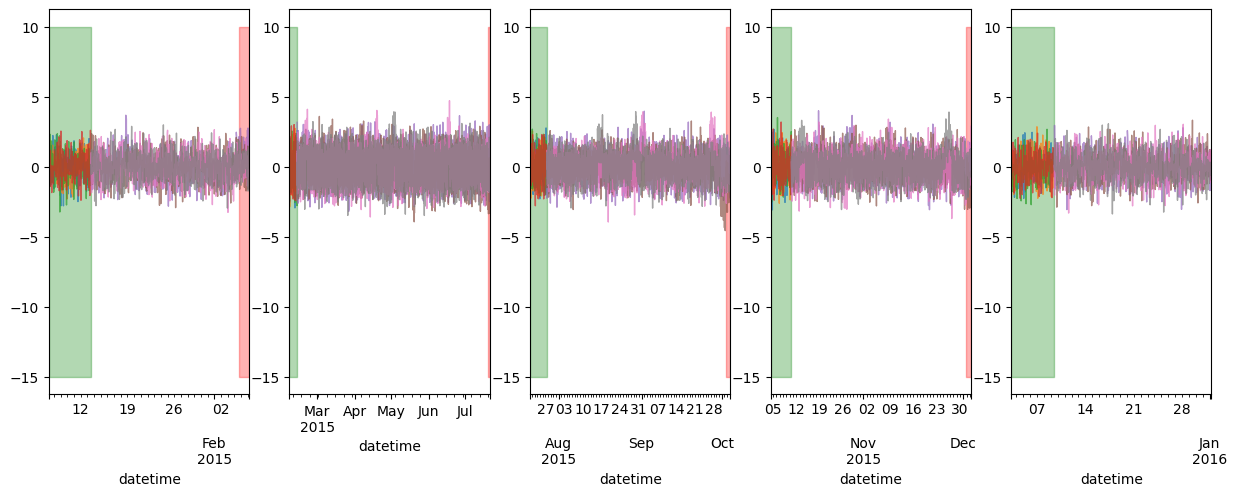

In [4]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, len(list_test)]

fig, axes = plt.subplots(nrows=1, ncols=len(list_test))
counter=0

scaler = StandardScaler()

for dftrain, dftest,isf in zip(list_train, list_test,isfailure):
    plot_scale_df(dftrain,axes[counter])
    axes[counter].fill_between(dftrain.index, -15, 10, color="green",
                        alpha=0.3, label="Profile")
    plot_scale_df(dftest,axes[counter])
    if isf==1:
        # lot Predictive Horizon
        time_36_hours_ago = dftest.index[-1] - datetime.timedelta(hours=36)
        last_36_hours = dftest[dftest.index >= time_36_hours_ago]
        axes[counter].fill_between(last_36_hours.index, -15, 10, color="red",
                        alpha=0.3, label="PH")
    counter+=1

plt.show()

# Initial Solution

0.4720496894409938


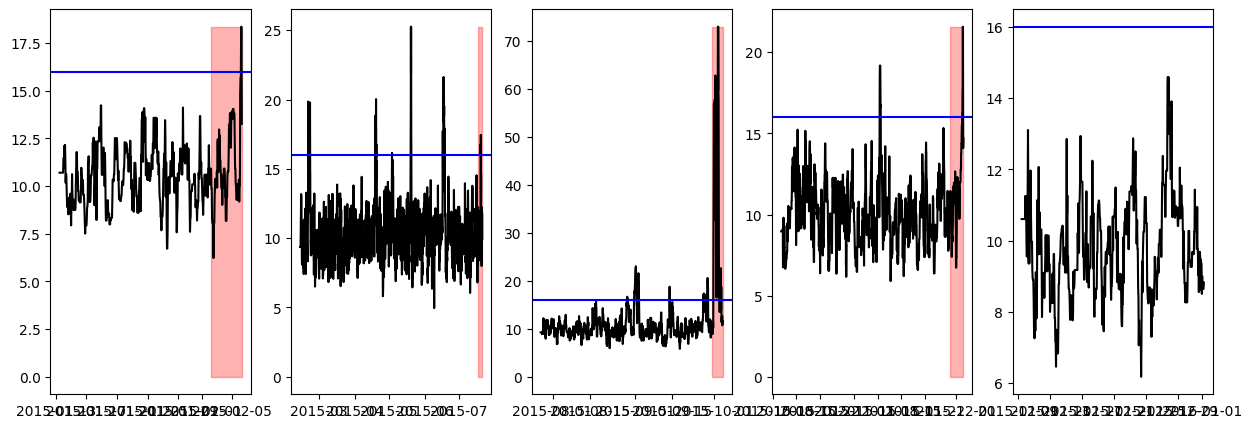

In [5]:
%matplotlib inline
import evaluation.evaluation as eval

fig, axes = plt.subplots(nrows=1, ncols=5)
counter=0
predictions_all=[]
dates_all =[] 
predictions_all2=[]

th=16
threshold=th
for dftrain, dftest in zip(list_train, list_test):
    scores=generate_scores(dftrain,dftest,methods.distance_based,window_for_threshold=0,smooth_window=10)
    predictions_all.extend(scores)
    axes[counter].plot(dftest.index,scores,color="black",label="anomaly scores")
    axes[counter].axhline(th,color="blue",label="threshold")
    # lot Predictive Horizon
    time_36_hours_ago = dftest.index[-1] - datetime.timedelta(hours=96)
    last_36_hours = dftest[dftest.index >= time_36_hours_ago]
    if counter<4:
        axes[counter].fill_between(last_36_hours.index, 0, max(scores), color="red",
                        alpha=0.3, label="PH")
    counter+=1

    # for evaluation
    predictions_all2.append(scores)
    # dates_all.append([dtt for dtt in dftest.index])
    dates_all.append([qi + counter for qi in range(len(dftest.index))])

recall, Precision, f1, FPR = eval.pdm_eval_multi_PH(predictions_all2,
                                                            [threshold for q in dates_all],
                                                            datesofscores=dates_all, isfailure=isfailure,
                                                            PH="96", lead="1", plotThem=False)
print(f1[0])

## Leveraging Flase positive from previus episodes

In [6]:
from PdmContext.ContextGeneration import ContextGenerator, ContextGeneratorBatch
from PdmContext.utils.causal_discovery_functions import calculate_with_pc
from PdmContext.utils.distances import distance_3D_sbd_jaccard
from PdmContext.utils.structure import Eventpoint


## Show Azure Data 

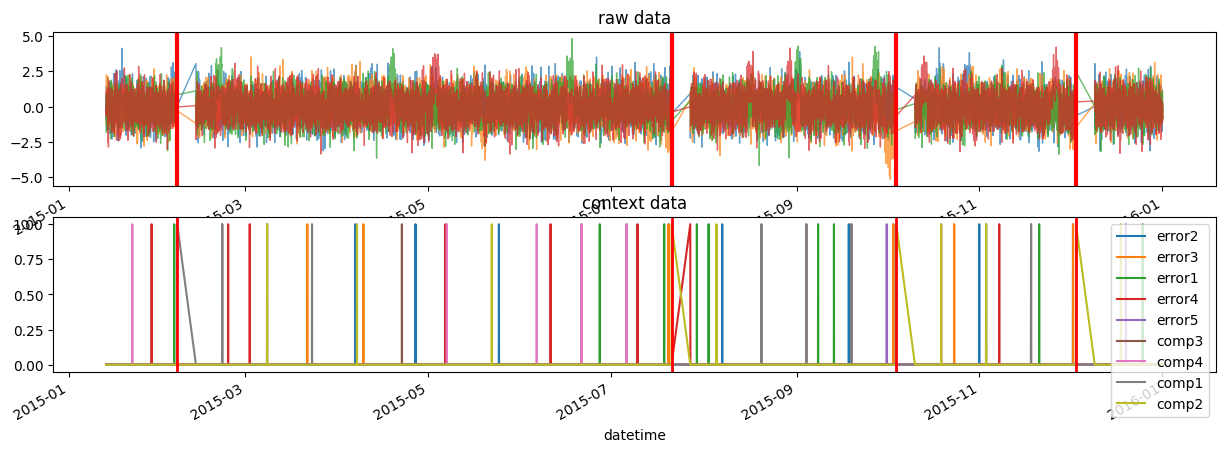

In [27]:
df,contextdata,dates,failures=read_Data.get_all_data(list_train, list_test, context_list_dfs)
failures=failures[:4]
fig, axes = plt.subplots(nrows=2, ncols=1)

contextdata=contextdata.diff().fillna(0)

axes[0].set_title("raw data")
plot_scale_df(df,axes[0])

axes[1].set_title("context data")
contextdata.plot(ax=axes[1])
for fail in failures:
    axes[0].axvline(fail,color="red",linewidth=3)
    axes[1].axvline(fail,color="red",linewidth=2)
plt.show()

## Define a similarity measure for context

In [19]:
threshold_similarity=0.8

def is_similar_to(context,false_positive_set,contexts,threshold_similarity):
    for dt in false_positive_set:
        similarity,_=distance_3D_sbd_jaccard(context, contexts[dt], a=0.5)
        #print(similarity)
        if similarity>threshold_similarity:
            return True
    return False

## Pipeline for Context and Feedback

In [23]:
context_gen =  ContextGenerator(target="score", context_horizon="48 hours", Causalityfunct=calculate_with_pc)
counter=-1
failure_counter=0
alarms=[]
pruned=[]
false_positive_set=[]
contexts={}
ALLalarms=[]
from tqdm import tqdm




# Iteratevly for all data
for counter in tqdm(range(len(df.index))):
    timestamp=df.index[counter]
    score=predictions_all[counter]
    row = df.iloc[counter]
    
    
    #collect df data:
    # for col in df.columns:
    #    context_gen.add_to_buffer(Eventpoint(code=col,details=row[col],  source="m", timestamp=timestamp),replace=[])
    #Generate context data:
    row = contextdata.iloc[counter]
    for col in contextdata.columns:
        if row[col]==1:
            context_gen.add_to_buffer(Eventpoint(code=col,details=row[col],  source="m", timestamp=timestamp,type="configuration"),replace=[])
                         
    # check for prunning
    if score>th:
        context=context_gen.collect_data(timestamp=timestamp, source="m", name="score",value=score)
        contexts[timestamp]=context
        alarms.append(timestamp)
        if is_similar_to(context,false_positive_set,contexts,threshold_similarity):
            pruned.append((timestamp,score))
            ALLalarms.append(0)
        else:
            ALLalarms.append(1)
    else:
        ALLalarms.append(0)
        context_gen.add_to_buffer(Eventpoint(code="score",details=score,  source="m", timestamp=timestamp),replace=[])
    
        
    # check for Feedback based on failure
    if failure_counter<4:                           
        if timestamp>=failures[failure_counter]:
            #print("add false positives")
            episode_fp=[time_dt for time_dt in alarms if failures[failure_counter] - time_dt>datetime.timedelta(hours=96)]
            false_positive_set.extend(episode_fp)
            alarms=[]
            failure_counter+=1

    
    


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7871/7871 [00:01<00:00, 4389.42it/s]


### Plot the result when feeadback Framework is used.

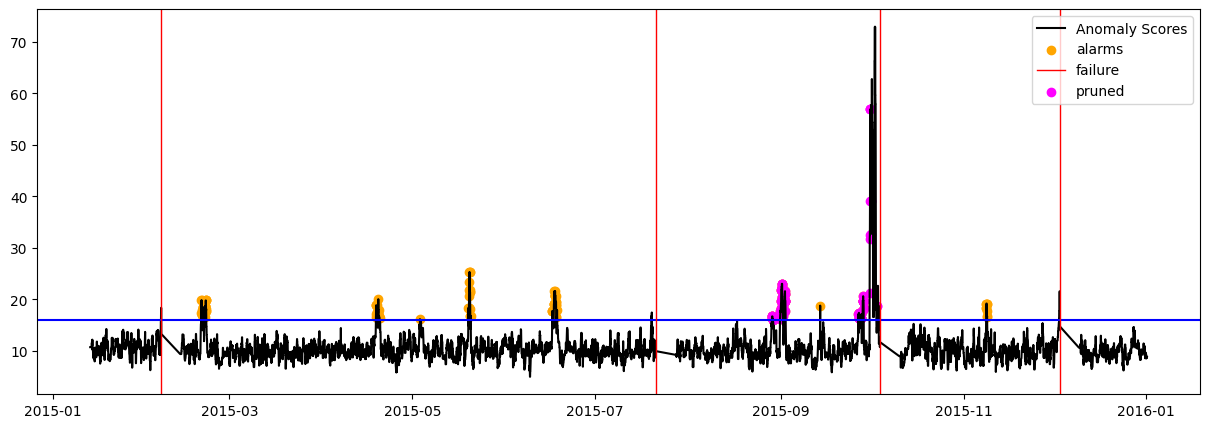

In [24]:
import matplotlib
%matplotlib inline


plt.plot(df.index,predictions_all,color="black",label="Anomaly Scores")
plt.axhline(th,color="blue")

fps_scores = [sc for sc,dt in zip(predictions_all,df.index) if dt in false_positive_set]


plt.scatter(false_positive_set,fps_scores,color="orange",label="alarms")


plt.axvline(failures[0],color="red",linewidth=1,label="failure")
for fail in failures[1:]:
    plt.axvline(fail,color="red",linewidth=1)

scores_pruned=[tup[1] for tup in pruned]
times_pruned=[tup[0] for tup in pruned]
plt.scatter(times_pruned,scores_pruned,color="magenta",label="pruned")

plt.legend()

### As we can see initial false positives after first failure (in yellow), are used to prune the purple ones in the next episode.


In [25]:
episodes=[f for f in failures]+[df.index[-1]]
recall, Precision, f1, FPR = eval.pdm_eval_multi_PH(ALLalarms,
                                                            [0.5 for q in df.index],maintenances=episodes,
                                                            datesofscores=df.index, isfailure=isfailure,
                                                            PH="96 hours", lead="1 hours", plotThem=False)
print(f1[0])

0.5565217391304349
